## 06. Close pair study using $X_{\rm off}/R_{\rm vir}$ 

This notebook studies if close pairs are sensitive to $X_{\rm off}/R_{\rm vir}$.

1. Loading data and defining input parameters
2. Using selected pairs to study the effect of $\tilde{X}_{\rm off} = X_{\rm off}/R_{\rm vir}$
2. Studying merger fraction $f_{MM}$ as a function of redshift

**Script written by**: Soumya Shreeram <br>
**Project supervised by**: Johan Comparat <br>
**Date**: 11th May 2021

Import required packages

In [15]:
# astropy modules
import astropy.units as u
import astropy.io.fits as fits

from astropy.table import Table, Column
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM, z_at_value

import numpy as np

# system imports
import os
import sys
import importlib as ib

# plotting imports
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import norm

Load the imported file(s) that contains all the functions used in this notebooks

In [2]:
%matplotlib inline
font = {'family' : 'serif',
        'weight' : 'medium',
        'size'   : 20}
matplotlib.rc('font', **font)

In [3]:
sys.path.append('imported_files/')
import Exploring_DM_Halos as edh
import Agn_incidence_from_Major_Mergers as aimm
import Comparison_simulation_with_literature_data as cswl
import plotting_cswl05 as pt

### 1. Defining input parameters

In [4]:
# look back into redshifts until...
redshift_limit = 2

# pixel number from the simulation file
pixel_no = '000000'

# define color palatte
pal = sns.hls_palette(10, h=.5, s=1).as_hex()

Define cosmology used in the notebook

In [5]:
cosmo = FlatLambdaCDM(H0=67.77*u.km/u.s/u.Mpc, Om0=0.307115)
h = 0.6777
L_box = 1000.0 / h

vol = cosmo.comoving_volume(redshift_limit)*(53)/(129600/np.pi)

Parameters for creating the Major Merger catalogue.

In [124]:
# get shell volume and projected radius bins [Mpc]
r_p, shell_volume = aimm.shellVolume()

# normalized xoff array 
xoff_arr = [0.1, 0.2, 0.3, 0.4, 0.5]

# max mass ratio to classify as a major merger [dimensionless]
mass_max = 3

# defining the redshift bin for a merger in terms of dv = c*z [km/s]
dz_cut = 0.001

Booleans if one wants to skip running parts of the code

### 2. Open files and get relevant data

In [7]:
_, hd_halo, _ = edh.getHeaders(pixel_no, np.array(['agn', 'halo']))

Extracting positions and redshifts of the AGNs, galaxies, and halos

In [8]:
# halos
_, _, conditions_halo = edh.getGalaxyData(hd_halo, '', redshift_limit)
hd_z_halo = hd_halo[conditions_halo]
print("Halos: %d"%(len(hd_z_halo) ))

Halos: 4506611


### 3. Generate control sample

In order to quantify an excess in the pairs as a function of seperation, we need to compute a relative 'control sample'. This control is constructed by executing the following steps:

* For a given pair, $p$, at a separation, $r$, all the halos pairs (generated without MM, $\Delta v$ selection; *no selection paired halos*) that have similar mass ratio $M_1/M_2$ are chosen.

* The mass-matched sample is then processed further to be redshift-matched i.e. it should be in the same mean redshift range $\pm 0.1$ as $p$. 

* Now, 1 data point on the plot is the sum of all the paired halos at that separation, r. So similarly, I sum all the *no selection paired halos* that pass the redshift & mass criteria to generate a comparable value of number density for the 'control' sample at any given separation.


The code that executes this can be found in `Generate_control_sample.py`, with it's corresponding function in `cswl`. 

In [9]:
num_mm_control_pairs = []
for r in range(len(r_p)):
    mz_matched_mm_control = np.load('Data/pairs_z%.1f/Major_dv_pairs/control_pairs_idx_r%.1f_mz.npy'%(redshift_limit, r), allow_pickle=True)
    
    # get the total number of 'no selection pairs' for the chosen separation
    num_mm_control_pairs.append(np.sum(mz_matched_mm_control))

### 4.  Loading halo pairs (with and without selection cuts)


The pairs are computed on the cluster with the ball tree algorithm. Refer to the python file for further details: `05_Preliminary_comparison_of_simulations_AGN_fraction_with_data.py` (same name as this notebook. The default values used were:
1. `mass_min = 0.33`, `mass_max = 3`
2. `dv_cut = 500`  

Can change these keywords in functions 1 and 2, respectively in the `.py` file.

The pairs computed in the last step is written to the directory `'Data/pos_z2/'`. Here, the pair indicies generated from the ball tree algorithm are loaded for further analysis.

In [10]:
pairs_all = cswl.openPairsFiles(key = 'all')
pairs_dv_all = cswl.openPairsFiles(key = 'dv', dz_cut=dz_cut)
pairs_mm_all = cswl.openPairsFiles(key = 'mm')
pairs_mm_dv_all = cswl.openPairsFiles(key = 'mm and dv')

Plotting $n_{\rm{ halo\ pairs}}$ as a function of $r_p$, where $n_{\rm{ halo\ pairs}}$:

$$n_{\rm{ halo\ pairs}}\ \rm{[Mpc^{-3}]} \ = \frac{\rm{ NP\ (\ selection \ criterion)}}{\rm{ N(N-1)} \times {\rm Shell\ volume}}$$

where $NP$ is the number of pairs in the shell and $N$ is the total number of objects from which pairs are chosen. The selection criteria could be mass ratio $3:1$ or $\Delta z < 10^{-3}$ or both.

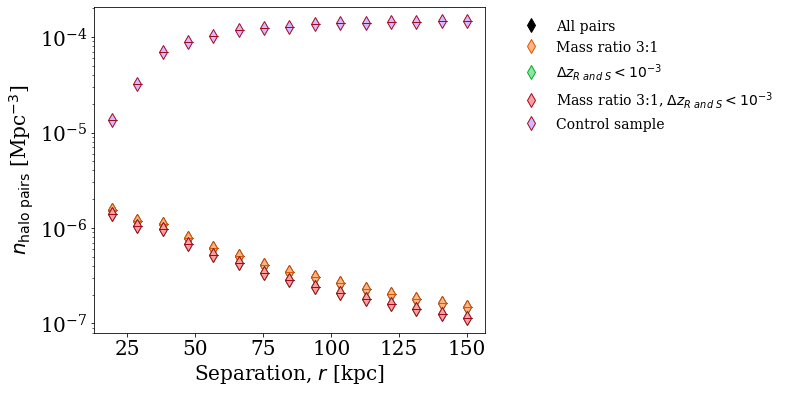

In [11]:
pairs_arr, pairs_arr_err = pt.plotFracNdensityPairs(hd_z_halo, pairs_all, pairs_mm_all, pairs_dv_all, pairs_mm_dv_all, num_mm_control_pairs)
#plt.savefig('figures/f_halo_pairs_new.pdf', facecolor='w', edgecolor='w', bbox_inches='tight')

# extract the info saven in objects
n_pairs, n_mm_pairs, n_dv_pairs, n_mm_dv_pairs, n_mz_control_pairs = pairs_arr
n_pairs_err, n_pairs_mm_err, n_pairs_dv_err, n_mz_control_err = pairs_arr_err

### 5. Studying the $\tilde{X}_{\rm off}$ distribution

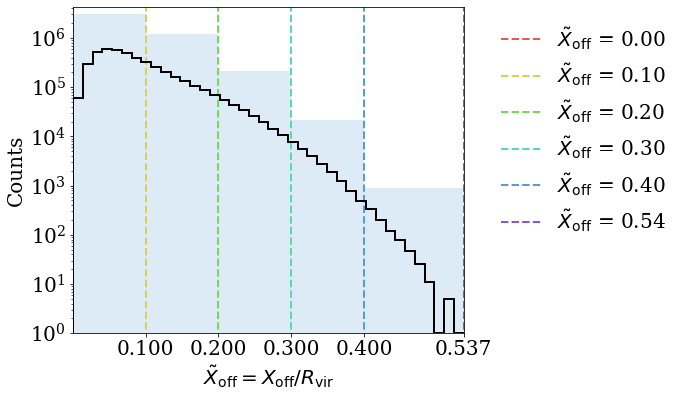

In [133]:
fig, ax = plt.subplots(1,1,figsize=(7,6))
pal = sns.color_palette("hls", len(xoff_arr)+1).as_hex()
xoff_min, xoff_max = np.min(xoff_all), np.max(xoff_all)
xoff_arr = [0, 0.1, 0.2, 0.3, 0.4, xoff_max]
hd_halo_z = hd_halo[conditions_halo]
xoff_all = hd_z_halo['HALO_Xoff']/hd_z_halo['HALO_Rvir']

counts_xoff, _, _ = ax.hist(xoff_all, bins=40, histtype='step', color='k', lw=2)

out = ax.hist(xoff_all, bins=[0, 0.1, 0.2, 0.3, 0.4, xoff_max], histtype='bar', color=pal[4], alpha=0.2, align='mid')
ax.set_yscale('log')
ax.set_xticks(xoff_arr)
for i, xoff_cut in enumerate(xoff_arr):
    ax.vlines(xoff_cut, 0, 7*np.max(counts_xoff), linestyles='--', linewidths=2, colors=pal[i], label=r'$\tilde{X}_{\rm off}$ = %.2f'%xoff_cut)

ax.set_yscale('log')
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
pt.setLabel(ax, r'$\tilde{X}_{\rm off} = X_{\rm off}/R_{\rm vir}$', r'Counts', '', [xoff_min, xoff_max], [1, 7*np.max(counts_xoff)], legend=False)
plt.savefig('figures/Xoff_dist.pdf', facecolor='w', edgecolor='w', bbox_inches='tight')

Plot the nornalizes cumulative distribution function

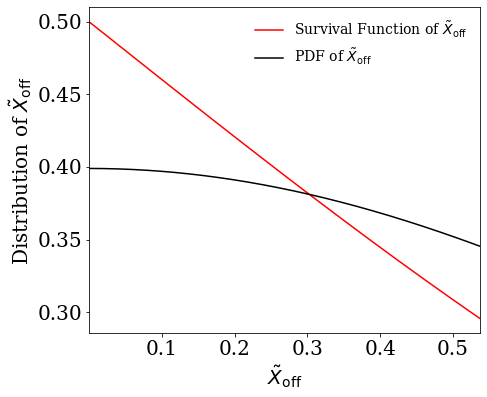

In [109]:
ib.reload(pt)
ax = pt.plotParameterDistributions(xoff_all)
plt.savefig('figures/Xoff_dist_function_bins.png', facecolor='w', edgecolor='w', bbox_inches='tight')

### 4. Studying the effect of $\tilde{X}_{\rm off}$ on close pairs

Now that all the pairs for the chosen cases of time since major mergers are computed, we can proceed to calculate the number density of halo pairs for each case.

$$n_{\rm{ halo\ pairs}}\ \rm{[Mpc^{-3}]} \ = \frac{\rm{ NP}\ (\ selection \ criterion)}{\rm{ N(N-1)} \times {\rm Shell\ volume}}$$

where $NP$ is the number of pairs and $N$ is the total number of objects from which pairs are chosen. Here, in addition to the selection criteria discussed about, the additional criteria of $\tilde{X}_{\rm off}$ is applied.

The Xoff/Rvir criteria was applied to the selected pairs (code can again be found in the `05_Pre...data.py` file). Corresponding function can be found in the `cswl` imported file. Here the chosen pair indicies are loads.

In [14]:
n_pairs_xoff_all = cswl.concatAllTmmFiles(xoff_arr, key = 'all', param='x_off')
n_pairs_mm_dv_xoff_all = cswl.concatAllTmmFiles(xoff_arr, key = 'mm and dv', param='x_off')

$$f_{\rm halo\ pairs} = \frac{n_{\rm pairs}(\rm Mass\ ratio\ < 3:1; \Delta \ v < 500 km\ s^{-1})}{n_{\rm \ pairs}(\rm No \ selection \ criteria)}$$

Plot shows that the major merger (mass ratio) criteria with the $\Delta v$ criterion or redshift criterion as $\Delta v = c \Delta z$. It is the cumulative number of pairs distribution divided with the total volume at $z<2$

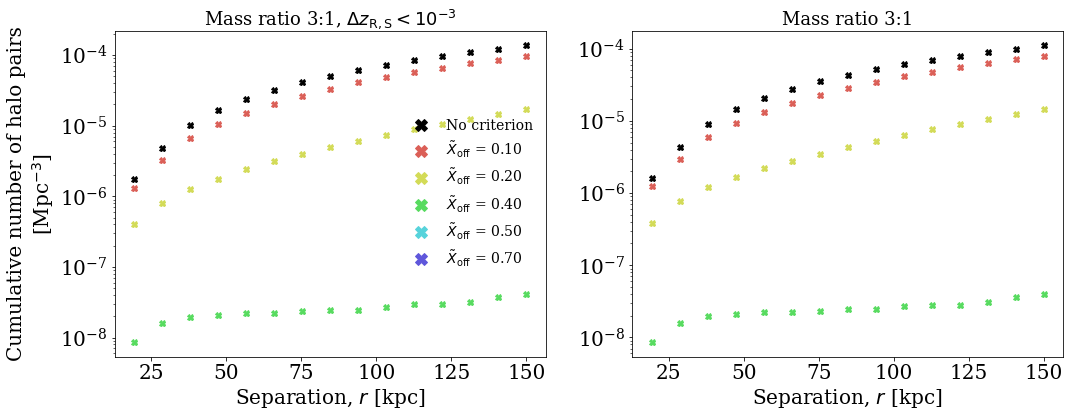

In [16]:
ib.reload(pt)
pal = pt.plotCumulativeDist(vol, xoff_arr, pairs_all, pairs_mm_dv_all, n_pairs_xoff_all, n_pairs_mm_dv_xoff_all, param = 'x_off')

Cumulative number of pairs distribution divided with the total pairs without $\tilde{X}_{\rm off}$ criterion

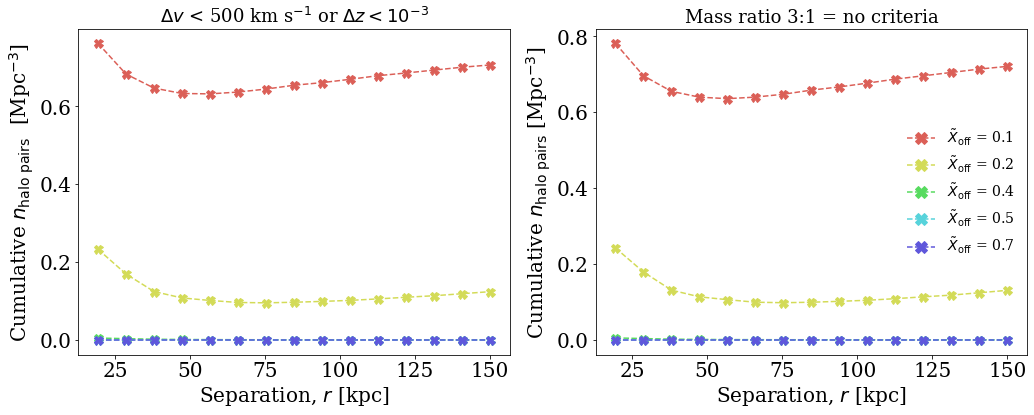

In [18]:
fig, ax = plt.subplots(1,2,figsize=(17,6))

for xoff in range(len(xoff_arr)):
    np_mm_xoff, np_mm_dv_xoff = n_pairs_xoff_all[xoff], n_pairs_mm_dv_xoff_all[xoff]    

    ax[0].plot( (1e3*r_p[1:]), (np_mm_xoff[1:]/(pairs_all[1][1:])), 'kX', ls = '--', color=pal[xoff], mec = pal[xoff], ms=9)
    ax[1].plot( (1e3*r_p[1:]), (np_mm_dv_xoff[1:]/(pairs_mm_dv_all[1][1:])), 'kX', ls = '--', color=pal[xoff], label = r'$\tilde{X}_{\rm off}$ = %.1f'%xoff_arr[xoff], ms = 9,mec = pal[xoff])

pt.setLabel(ax[0], r'Separation, $r$ [kpc]', r'Cumulative $n_{\rm halo\ pairs}}$  [Mpc$^{-3}$]', r'$\Delta v$ < 500 km s$^{-1}$ or $\Delta z < 10^{-3}$', 'default', 'default', legend=False)
pt.setLabel(ax[1], r'Separation, $r$ [kpc]', r'Cumulative $n_{\rm halo\ pairs}}$ [Mpc$^{-3}$]', 'Mass ratio 3:1 = no criteria', 'default', 'default', legend=True)

Now there is an additional condition in pair selection: $\tilde{X}_{off}=x$, where $x$ goes from $0.01$ Gyr to $0.4$.

$$f_{\rm halo\ pairs} = \frac{n_{\rm pairs}(\rm Mass\ ratio\ < 3:1; \Delta \ v < 500 km\ s^{-1};\ \tilde{X}_{off}=x)}{n_{\rm total\ pairs}}$$

/home/shreeram/miniconda3/envs/eroconda/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/shreeram/miniconda3/envs/eroconda/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/shreeram/miniconda3/envs/eroconda/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: invalid value encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home/shreeram/miniconda3/envs/eroconda/lib/python3.7/site-packages/numpy/core/_asarray.py:102: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)
/home/shreeram/miniconda3/envs/eroconda/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarnin

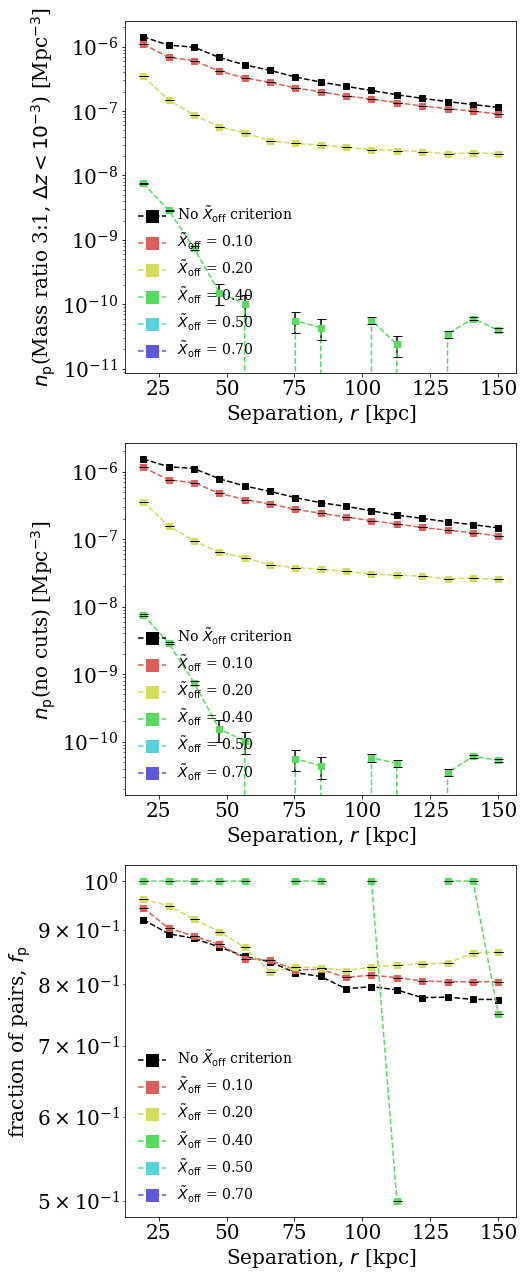

In [23]:
ib.reload(pt)
fig, ax = plt.subplots(3,1,figsize=(7,22))
r_p_kpc = (1e3*r_p)
f_p_selection = np.zeros((0, len(r_p[1:])))

ax[0].plot(r_p_kpc[1:], n_mm_dv_pairs, 'ks', ls='--', label=r'No $\tilde{X}_{\rm off}$ criterion')
ax[1].plot(r_p_kpc[1:], n_pairs, 'ks', ls='--', label=r'No $\tilde{X}_{\rm off}$ criterion')
ax[2].plot(r_p_kpc[1:], n_mm_dv_pairs/n_pairs, 'ks', ls='--', label=r'No $\tilde{X}_{\rm off}$ criterion')

for xoff in range(len(xoff_arr)):
    np_mm_xoff, np_mm_dv_xoff = n_pairs_xoff_all[xoff], n_pairs_mm_dv_xoff_all[xoff]    
    
    # shell pair density (I) with mass ratio and (II) with mass ratio and redshift cuts
    n_p_mm, n_p_mm_err = cswl.nPairsToFracPairs(hd_z_halo, np_mm_xoff)
    n_p_mm_dv, n_p_mm_dv_err = cswl.nPairsToFracPairs(hd_z_halo, np_mm_dv_xoff)
    
    # plot 1 and 2 (plotting the fractional pair density for case I and II)
    _ = pt.plotFpairs(ax[0], r_p, n_p_mm_dv, n_p_mm_dv_err, label = r'$\tilde{X}_{\rm off}$ = %.2f'%xoff_arr[xoff], color=pal[xoff])
    _ = pt.plotFpairs(ax[1], r_p, n_p_mm, n_p_mm_err, label = r'$\tilde{X}_{\rm off}$ = %.2f'%xoff_arr[xoff], color=pal[xoff])
    
    # get absolute fraction by dividing n_p(with cuts, Tmm = t)/n_p(no cuts, Tmm = t)
    _ = pt.plotFpairs(ax[2], r_p, n_p_mm_dv/n_p_mm, n_p_mm_err, label = r'$\tilde{X}_{\rm off}$ = %.2f'%xoff_arr[xoff], color=pal[xoff])
    f_p_selection = np.append(f_p_selection, [n_p_mm_dv/n_p_mm], axis=0)
np.save('Data/pairs_z%.1f/Major_dv_pairs/f_p_wrt_mm_xoff.npy'%redshift_limit, f_p_selection, allow_pickle=True)
    
pt.setLabel(ax[0], r'Separation, $r$ [kpc]', r'$n_{\rm p}}$(Mass ratio 3:1, $\Delta z < 10^{-3}$) [Mpc$^{-3}$]', '', 'default', 'default', legend=True)
pt.setLabel(ax[1], r'Separation, $r$ [kpc]', r'$n_{\rm p}}$(no cuts) [Mpc$^{-3}$] ', '', 'default', 'default', legend=True)
pt.setLabel(ax[2], r'Separation, $r$ [kpc]', r'fraction of pairs, $f_{\rm p}$', '', 'default', 'default', legend=True)

[ax[i].set_yscale('log') for i in [0, 1, 2]]
plt.savefig('figures/f_halo_pairs_xoff.pdf', facecolor='w', edgecolor='w', bbox_inches='tight')

Now, let's look at the fraction with respect to the mass matched control sample (more relavant for comparison to observations).

Plot generated with respect to the control sample.

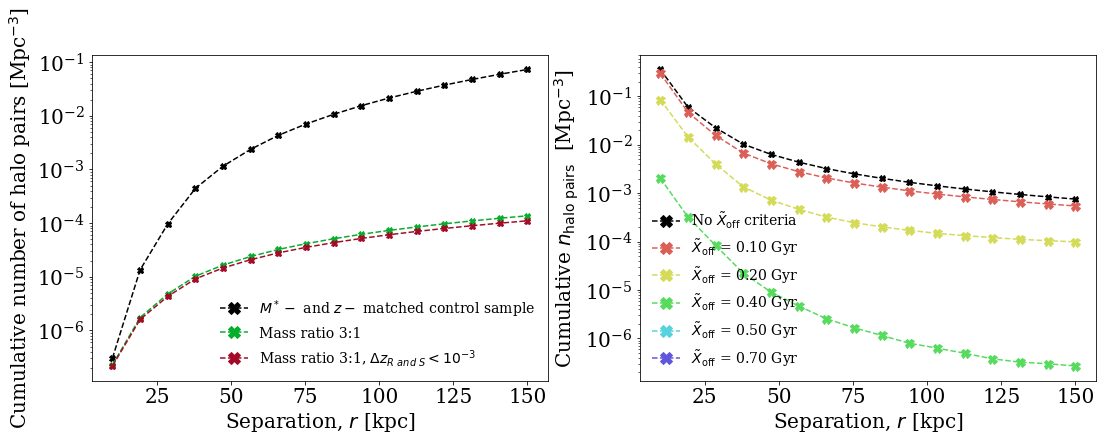

In [24]:
fig, ax = plt.subplots(1,2,figsize=(18,6))

# plot control curve
ax[0].plot((1e3*r_p), (num_mm_control_pairs/(2*vol)), 'kX', ls='--', label='$M^*-$ and $z-$ matched control sample')
ax[0].plot( (1e3*r_p), (pairs_mm_all[1]/(2*vol)), 'X', ls='--', color='#05ad2c', label=r'Mass ratio 3:1')
ax[0].plot( (1e3*r_p), (pairs_mm_dv_all[1]/(2*vol)), 'X', ls='--', color='#a30a26', label=r'Mass ratio 3:1, $\Delta z_{R\ and\ S }  < 10^{-3} $')
ax[0].set_yscale('log')

# red curve/ black curve
ax[1].plot( (1e3*r_p), (pairs_mm_dv_all[1]/(2*np.array(num_mm_control_pairs))), 'kX', ls='--', label=r'No $\tilde{X}_{\rm off}$ criteria')

for xoff in range(len(xoff_arr)):
    np_mm_dv_xoff = n_pairs_mm_dv_xoff_all[xoff]    
    
    # plot tmm cuts
    ax[1].plot((1e3*r_p), (np_mm_dv_xoff/(2*np.array(num_mm_control_pairs))), 'X', label = r'$\tilde{X}_{\rm off}$ = %.2f Gyr'%xoff_arr[xoff], ls = '--', color=pal[xoff], mec = pal[xoff], ms=9)

ax[1].set_yscale('log')
pt.setLabel(ax[0], r'Separation, $r$ [kpc]', r'Cumulative number of halo pairs [Mpc$^{-3}$]', '', 'default', 'default', legend=True)
pt.setLabel(ax[1], r'Separation, $r$ [kpc]', r'Cumulative $n_{\rm halo\ pairs}}$  [Mpc$^{-3}$] ', '', 'default', 'default', legend=True)
plt.savefig('figures/f_halo_pairs_mz_control_xoff.pdf', facecolor='w', edgecolor='w', bbox_inches='tight')

Now instead of the cumulative distribution, we are interested in the number of pairs in each shell wrt the control sample.

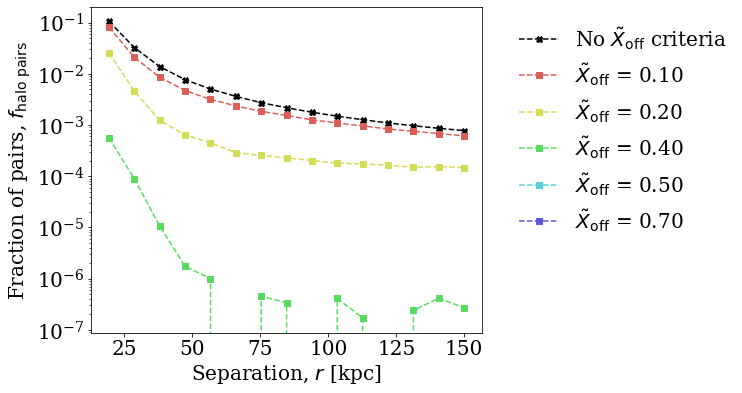

In [25]:
fig, ax = plt.subplots(1,1,figsize=(7,6))
f_p_selection_c = np.zeros((0, len(r_p[1:])))

# plotting the pairs without the Tmm criteria
ax.plot( (1e3*r_p[1:]), (n_mm_dv_pairs/n_mz_control_pairs), 'kX', ls='--', label=r'No $\tilde{X}_{\rm off}$ criteria')
for xoff in range(len(xoff_arr)):
    np_mm_dv_xoff = n_pairs_mm_dv_xoff_all[xoff]    
    
    # fractional pair density (I) with mass ratio and (II) with mass ratio and redshift cuts
    n_p_mm_dv, n_p_mm_dv_err = cswl.nPairsToFracPairs(hd_z_halo, np_mm_dv_xoff)
    
    # get absolute fraction by dividing n_p(with cuts, Tmm = t)/n_p(no cuts, Tmm = t)
    _ = pt.plotFpairs(ax, r_p, n_p_mm_dv/n_mz_control_pairs, n_p_mm_err, label = r'$\tilde{X}_{\rm off}$ = %.2f'%xoff_arr[xoff], color=pal[xoff], errorbar = False)
    f_p_selection_c = np.append(f_p_selection_c, [n_p_mm_dv/n_mz_control_pairs], axis=0)
np.save('Data/pairs_z%.1f/Major_dv_pairs/f_p_wrt_mz_control_xoff.npy'%redshift_limit, f_p_selection_c, allow_pickle=True)

ax.set_yscale('log')
pt.setLabel(ax, r'Separation, $r$ [kpc]', r'Fraction of pairs, $f_{\rm halo\ pairs}}$ ', '', 'default', 'default', legend=True)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

plt.savefig('figures/f_halo_pairs_mz_control_xoff_shell.pdf', facecolor='w', edgecolor='w', bbox_inches='tight')